<a href="https://colab.research.google.com/github/N1c-C/TTS/blob/main/T5Generation_playtback_and_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install speechbrain
# !pip install datasets


In [ ]:
!pip install --upgrade speechbrain

Modules

In [ ]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import torch
import scipy.io.wavfile
import speechbrain as sb

# Model to generate X-Vector voice embedding
from speechbrain.pretrained import EncoderClassifier

# Text Preprocessor model and SpeachT5 TTS model
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

# from datasets import load_dataset

# Vocoder converts logmel spectrogram to an audio waveform
from transformers import SpeechT5HifiGan

ModuleNotFoundError: No module named 'speechbrain.pretrained'

In [ ]:

def resample(waveform, fs, new_fs):
  """Resample waveform to new_fs
  Param: waveform as torch tensor - use torchaudio.load
  param: fs: current sample rate as int
  param: new_fs:required sample rate as int """
  resampler = torchaudio.transforms.Resample(fs, new_fs)
  return resampler(waveform)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

def plot_spectrogram(spectrogram):
  plt.figure()
  plt.imshow(spectrogram.numpy().T, aspect="auto", interpolation="nearest", origin="lower")
  plt.xlabel("Frames")
  plt.ylabel("Frequency bins")
  plt.title("Spectrogram of the generated speech")
  plt.show()






# Make a Speaker Embedding From a Wav Sample

In [ ]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)
waveform, fs = torchaudio.load('/content/nc2.wav')
waveform = resample(waveform, fs, 16000)
speaker_embedding = create_speaker_embedding(waveform)

In [ ]:
# Alternate option

# from speechbrain.inference.speaker import EncoderClassifier
# classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

# embeddings = classifier.encode_batch(signal)

In [ ]:
print(speaker_embedding.shape)

torch.Size([1, 1, 512])


In [ ]:
torch.save(speaker_embedding, 'embedding.pt')
torch.load('embedding.pt')

# Lets Do Some Talking

### Generate a spectrogram from the text

In [ ]:
# Load the pretrained models
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [ ]:
inputs = processor(text="To be or not to be! That is the question", return_tensors="pt")
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embedding)
spectrogram.shape

In [ ]:
# American voice dataset
# embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

# Look at the generated Spectrogram

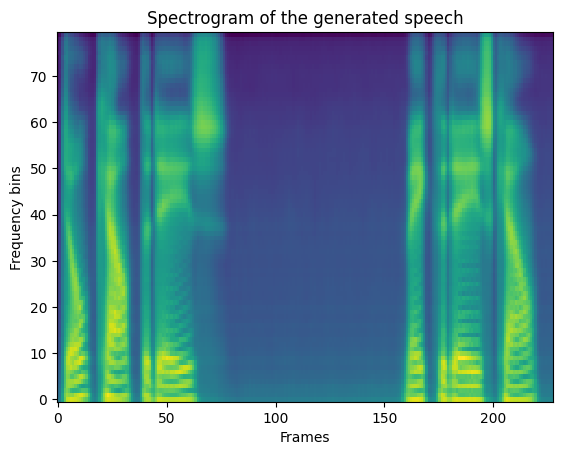

In [ ]:
plot_spectrogram(spectrogram)

In [ ]:
# Load the pretrained vocoder to convert spectrogram to speech
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
speech = model.generate_speech(inputs["input_ids"], speaker_embedding, vocoder=vocoder)
Audio(speech, rate=16000)
scipy.io.wavfile.write("output.wav", rate=16000, data=speech.numpy())